In [1]:


from datetime import datetime

import torch
from torch.utils.data import DataLoader

from datasets.CustomTrainingImageDataset import generate_balanced_dataset
from models.inception import InceptionV3Model
from models.resnet import Resnet50Model
from train import train_classifier
from utils import plot_model_metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 32

train_dataset, test_dataset = generate_balanced_dataset('data/DeepHP', discard_ratio=0.9, undersample=False)
print(f"Dataset: {len(train_dataset):,} training, {len(test_dataset):,} testing examples")

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True, )

test_loader = DataLoader(test_dataset,  #Subset(test_dataset, np.arange(1)),
                         batch_size=batch_size,
                         shuffle=True,
                         )

model = InceptionV3Model()


Device: cuda:0
Dataset: 27,644 training, 11,848 testing examples


In [2]:

print(model)

InceptionV3Model(
  (pretrained_model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2

In [3]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2024-08-30T16:46:17.971617


In [ ]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, test_loader, device,
                                        learning_rate=0.0001,
                                        max_epochs=20,
                                        checkpoint_every=None,
                                        eval_every=5)

Epoch 1 training:  56%|█████▌    | 484/864 [00:42<00:33, 11.47it/s]

Training ends 2024-08-30T16:23:10.116606
Test accuracy: 0.6090940422038862
Test precision: 0.2812406660692951
Test recall: 0.6090940422038862
Test f1: 0.2682511172429113


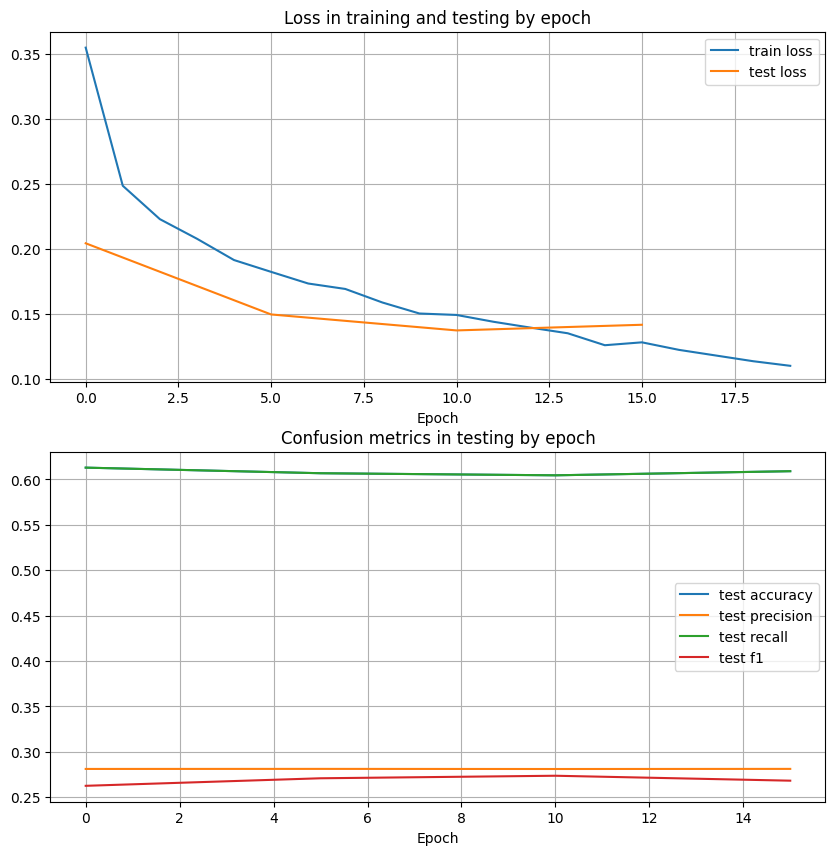

In [5]:
print(f"Training ends {datetime.now().isoformat()}")
for metric in ["accuracy", "precision", "recall", "f1", "mcc"]:
    if len(model_metrics[f"test_{metric}"]) > 0:
        print(f"Test {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)

In [7]:

torch.save(model.state_dict(), "./model5.bin")


Evaluating model: 100%|██████████| 93/93 [00:24<00:00,  3.78it/s]


{'accuracy': 0.5991958462193432,
 'loss': 0.13211213188466206,
 'precision': 0.28117532855436084,
 'recall': 0.5991958462193432,
 'f1': 0.2805753885420079,
 'mcc': 0.0}